### Questions

1. Examine the provided data. Are there any differences in properties of behaviour between those customers that subscribe and those that do not?

2. Construct a model to predict if a customer will subscribe after their free trial and demonstrate its performance.

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
raw_data_attributes = pd.read_csv('attributes_report.csv')
raw_data_attributes.head(10)

,company,company_type,subscribed_after_free_trial
0,346782,uk_limited_company,False
1,346783,uk_limited_company,False
2,346784,uk_limited_company,True
3,346785,uk_limited_company,False
4,346786,uk_limited_company,False
5,346787,uk_limited_company,False
6,346788,uk_limited_company,False
7,346789,uk_limited_company,False
8,346790,uk_limited_company,False
9,346791,uk_limited_company,False


In [4]:
data_attributes = pd.DataFrame(raw_data_attributes)
print(data_attributes.company_type.unique())

['uk_limited_company' 'uk_sole_trader' 'universal_company']


In [5]:
with open('engagement_report.log') as f:
    raw_data_logs = f.readlines()

In [6]:
data_logs = pd.DataFrame(columns=['company', 'day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7'])

In [47]:
# week_days = 1
# i = 0
# while i < len(raw_data_logs):
#     row = []
#     company = raw_data_logs[i][8:14]
#     day1 = int(raw_data_logs[i][25:26])
#     day2 = int(raw_data_logs[i + 1][25:26])
#     day3 = int(raw_data_logs[i + 2][25:26])
#     day4 = int(raw_data_logs[i + 3][25:26])
#     day5 = int(raw_data_logs[i + 4][25:26])
#     day6 = int(raw_data_logs[i + 5][25:26])
#     day7 = int(raw_data_logs[i + 6][25:26])
    
#     row = [company, day1, day2, day3, day4, day5, day6, day7]
#     data_logs.loc[i] = row
    
#     i += 7

record_index = 0    
for day in range(len(raw_data_logs)):
    if (day % 7 == 0):
        row = []
        company = int(raw_data_logs[day][8:14])
        day1 = int(raw_data_logs[day][25:26])
        day2 = int(raw_data_logs[day + 1][25:26])
        day3 = int(raw_data_logs[day + 2][25:26])
        day4 = int(raw_data_logs[day + 3][25:26])
        day5 = int(raw_data_logs[day + 4][25:26])
        day6 = int(raw_data_logs[day + 5][25:26])
        day7 = int(raw_data_logs[day + 6][25:26])        
        
        row = [company, day1, day2, day3, day4, day5, day6, day7]
        data_logs.loc[record_index] = row
        record_index += 1

In [80]:
data = pd.merge(data_attributes, data_logs, on='company', how='inner')
data.head()

,company,company_type,subscribed_after_free_trial,day1,day2,day3,day4,day5,day6,day7
0,346782,uk_limited_company,False,1,0,1,0,1,0,0
1,346783,uk_limited_company,False,0,0,0,0,0,0,0
2,346784,uk_limited_company,True,1,0,0,1,4,1,0
3,346785,uk_limited_company,False,0,0,0,0,0,0,0
4,346786,uk_limited_company,False,0,0,0,0,0,0,0


In [91]:
data_no_sub = data.loc[data['subscribed_after_free_trial'] == False]

num_rows = len(data_no_sub)

data_no_sub_avg_day1 = data_no_sub['day1'].sum() / num_rows
data_no_sub_avg_day2 = data_no_sub['day2'].sum() / num_rows
data_no_sub_avg_day3 = data_no_sub['day3'].sum() / num_rows
data_no_sub_avg_day4 = data_no_sub['day4'].sum() / num_rows
data_no_sub_avg_day5 = data_no_sub['day5'].sum() / num_rows
data_no_sub_avg_day6 = data_no_sub['day6'].sum() / num_rows
data_no_sub_avg_day7 = data_no_sub['day7'].sum() / num_rows


data_no_sub_all_days = [data_no_sub_avg_day1, data_no_sub_avg_day2, data_no_sub_avg_day3, data_no_sub_avg_day4, data_no_sub_avg_day5, data_no_sub_avg_day6, data_no_sub_avg_day7]


In [93]:
data_yes_sub = data.loc[data['subscribed_after_free_trial'] == True]

num_rows = len(data_yes_sub)

data_yes_sub_avg_day1 = data_yes_sub['day1'].sum() / num_rows
data_yes_sub_avg_day2 = data_yes_sub['day2'].sum() / num_rows
data_yes_sub_avg_day3 = data_yes_sub['day3'].sum() / num_rows
data_yes_sub_avg_day4 = data_yes_sub['day4'].sum() / num_rows
data_yes_sub_avg_day5 = data_yes_sub['day5'].sum() / num_rows
data_yes_sub_avg_day6 = data_yes_sub['day6'].sum() / num_rows
data_yes_sub_avg_day7 = data_yes_sub['day7'].sum() / num_rows


data_yes_sub_all_days = [data_yes_sub_avg_day1, data_yes_sub_avg_day2, data_yes_sub_avg_day3, data_yes_sub_avg_day4, data_yes_sub_avg_day5, data_yes_sub_avg_day6, data_yes_sub_avg_day7]


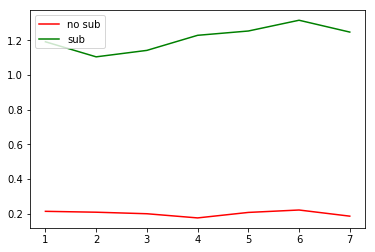

In [102]:
plt.plot([1, 2, 3, 4, 5, 6, 7], data_no_sub_all_days, color='r')
plt.plot([1, 2, 3, 4, 5, 6, 7], data_yes_sub_all_days, color='g')
plt.legend(['no sub', 'sub'], loc='upper left')
plt.show()

I think on average companies that subscribe go to the website at least two times and companies that don't subscribe <= 1; try to test it with standard deviation or smth

In [9]:
0 % 7

0